# Lending Club Loan Status Prediction


The project is to develop the best classification model for the Loan Status of the LendingClub Approved Loans from 2012-2015 and to evaluate how well your best model classifies the Loan Status of the loan in 2015.

## Table of Contents:
### 1. [Data Pre-processing](#step1)
### 2. [Exploratory Data Analysis](#step2)
### 3. [Feature Selection](#step3)
### 4. [Modelling](#step4)
        - Random Forest
        - XGBoost
        - Logistic Regression
        - KNN
### 4. [Predict loan status for 2015 using XGBoost](#step5)
### 5. [Conlusion](#step6)

In [183]:
# Import libraries

import numpy as np
import pandas as pd
from pandas import Series,DataFrame

import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# For evaluating ML results
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder


In [222]:
# import data
df = pd.read_csv("lending_club_data_2012_2014.csv", dtype = {19:"string", 49:"string", 129:"string",
                                                               130:"string", 131:"string", 134:"string",
                                                               135:"string",136:"string",139:"string"})


In [194]:
df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423810 entries, 0 to 423809
Data columns (total 152 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   id                                          int64  
 1   member_id                                   float64
 2   loan_amnt                                   int64  
 3   funded_amnt                                 int64  
 4   funded_amnt_inv                             float64
 5   term                                        object 
 6   int_rate                                    float64
 7   installment                                 float64
 8   grade                                       object 
 9   sub_grade                                   object 
 10  emp_title                                   object 
 11  emp_length                                  object 
 12  home_ownership                              object 
 13  annual_inc                  

In [23]:
data2 = pd.read_csv("lending_club_data_2015.csv", dtype = {19:"string", 59:"string"})

In [22]:
data2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Data columns (total 152 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   id                                          int64  
 1   member_id                                   float64
 2   loan_amnt                                   int64  
 3   funded_amnt                                 int64  
 4   funded_amnt_inv                             float64
 5   term                                        object 
 6   int_rate                                    float64
 7   installment                                 float64
 8   grade                                       object 
 9   sub_grade                                   object 
 10  emp_title                                   object 
 11  emp_length                                  object 
 12  home_ownership                              object 
 13  annual_inc                  

In [195]:
df.shape

(423810, 152)

In [25]:
data2.shape

(421095, 152)

In [28]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,year
0,36805548,NaN,10400,10400,10400.0,36 months,6.99,321.08,A,A3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2014
1,38098114,NaN,15000,15000,15000.0,60 months,12.39,336.64,C,C1,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2014
2,37822187,NaN,9600,9600,9600.0,36 months,13.66,326.53,C,C3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2014
3,37662224,NaN,7650,7650,7650.0,36 months,13.66,260.20,C,C3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2014
4,37612354,NaN,12800,12800,12800.0,60 months,17.14,319.08,D,D4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2014


### 1. Data Pre-processing <a class="anchor" id="step1"></a>


#### Handling Missing Values

From the general overview, I notice the number of variables in this dataset is big, and there are a large of missing values in some variables. So first, I will drop those columns with more than 30% missing values.

In [39]:
# Sort average of missing value for the entire dataset in ascending order
missing_data = df.isnull().mean().sort_values(ascending = False)*100
missing_data

sec_app_num_rev_accts                  100.0
sec_app_earliest_cr_line               100.0
sec_app_mths_since_last_major_derog    100.0
sec_app_collections_12_mths_ex_med     100.0
sec_app_chargeoff_within_12_mths       100.0
                                       ...  
out_prncp                                0.0
initial_list_status                      0.0
total_acc                                0.0
revol_bal                                0.0
id                                       0.0
Length: 152, dtype: float64

In [223]:
columns_to_drop = sorted(list(missing_data[missing_data > 30].index))


In [224]:
len(columns_to_drop)

58

In [225]:
df.drop(columns_to_drop, axis = 1, inplace = True)

After removing large missing value columns, we reduce to 94 columns, next, I will check Data Dictionary and only keep the features that would have been available to investors to consider, and I think it is useful to predict the loan status. I am using my best available knowledge to determine which features needed to be kept. 

In [226]:
pd.set_option('display.max_columns',None)
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,year
0,36805548,10400,10400,10400.0,36 months,6.99,321.08,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,58000.0,Not Verified,Dec-2014,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,937xx,CA,14.92,0,Sep-1989,710,714,2,17,0,6133,31.6,36,w,0.00,0.00,6611.69,6611.69,5217.75,872.67,0.0,521.27,93.8286,Aug-2016,321.08,Feb-2017,564,560,0,1,Individual,0,0.0,162110.0,19400.0,7.0,9536.0,7599.0,41.5,0,0,76.0,290.0,1.0,1.0,1.0,5.0,1.0,4.0,6.0,9.0,7.0,18.0,2.0,14.0,32.0,9.0,17.0,0.0,0.0,0.0,4.0,83.3,14.3,0,0,179407.0,15030.0,13000.0,11325.0,N,Cash,N,2014
1,38098114,15000,15000,15000.0,60 months,12.39,336.64,C,C1,MANAGEMENT,10+ years,RENT,78000.0,Source Verified,Dec-2014,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,235xx,VA,12.03,0,Aug-1994,750,754,0,6,0,138008,29.0,17,w,0.00,0.00,17392.37,17392.37,15000.00,2392.37,0.0,0.00,0.0000,Jun-2016,12017.81,Feb-2019,704,700,0,1,Individual,0,0.0,149140.0,184500.0,5.0,29828.0,9525.0,4.7,0,0,103.0,244.0,1.0,1.0,0.0,47.0,NaN,0.0,1.0,4.0,1.0,2.0,8.0,5.0,9.0,4.0,6.0,0.0,0.0,0.0,4.0,100.0,0.0,0,0,196500.0,149140.0,10000.0,12000.0,N,Cash,N,2014
2,37822187,9600,9600,9600.0,36 months,13.66,326.53,C,C3,Admin Specialist,10+ years,RENT,69000.0,Source Verified,Dec-2014,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,077xx,NJ,25.81,0,Nov-1992,680,684,0,12,0,16388,59.4,44,f,0.00,0.00,9973.43,9973.43,9600.00,373.43,0.0,0.00,0.0000,Apr-2015,9338.58,Jan-2019,679,675,0,1,Individual,0,0.0,38566.0,27600.0,8.0,3214.0,6494.0,69.2,0,0,183.0,265.0,23.0,3.0,0.0,24.0,17.0,0.0,4.0,7.0,5.0,16.0,17.0,8.0,26.0,7.0,12.0,0.0,0.0,0.0,3.0,100.0,60.0,0,0,52490.0,38566.0,21100.0,24890.0,N,Cash,N,2014
3,37662224,7650,7650,7650.0,36 months,13.66,260.20,C,C3,Technical Specialist,< 1 year,RENT,50000.0,Source Verified,Dec-2014,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,850xx,AZ,34.81,0,Aug-2002,685,689,1,11,0,16822,91.9,20,f,0.00,0.00,2281.98,2281.98,704.38,339.61,0.0,1237.99,222.8382,Aug-2015,17.70,Oct-2016,559,555,0,1,Individual,0,0.0,64426.0,18300.0,6.0,5857.0,332.0,93.2,0,0,137.0,148.0,8.0,8.0,0.0,17.0,3.0,0.0,1.0,4.0,1.0,4.0,12.0,4.0,8.0,4.0,11.0,0.0,0.0,0.0,2.0,100.0,100.0,0,0,82331.0,64426.0,4900.0,64031.0,N,Cash,N,2014
4,37612354,12800,12800,12800.0,60 months,17.14,319.08,D,D4,Senior Sales Professional,10+ years,MORTGAGE,125000.0,Verified,Dec-2014,Current,n,https://lendingclub.com/browse/loanDetail.acti...,car,Car financing,953xx,CA,8.31,1,Oct-2000,665,669,0,8,0,5753,100.9,13,w,2968.68,2968.68,15993.87,159

#### Encode response variable
There are more than two values in the *loan_status* column, in order to to fit our prediction model and easy for analysis, I will encode the *loan_status* to only two levels, 1 means "Fully Paid" and 0 means "Not Fully Paid"

In [227]:
# Check loan_status value
df['loan_status'].unique()

array(['Charged Off', 'Fully Paid', 'Current', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default'], dtype=object)

In [228]:
# Encode the loan status
df['loan_encode'] = np.where(df['loan_status'] == 'Fully Paid', 1, 0)

In [229]:
df['loan_encode'].value_counts()/len(df)

1    0.803294
0    0.196706
Name: loan_encode, dtype: float64

In [230]:
# Drop loan_status column and rename loan_encode to loan_status
df.drop(['loan_status'], axis = 1, inplace = True)
# Rename load_encode to loan_status 
df.rename(columns = {'loan_encode':'loan_status'}, inplace = True)

### 2. Exploratory Data Analysis <a class="anchor" id="step2"></a>
Since there are many features in the dataset, I choose some features that interest me for further analysis\n
#### 2.1 FICO Score vs. Loan Status

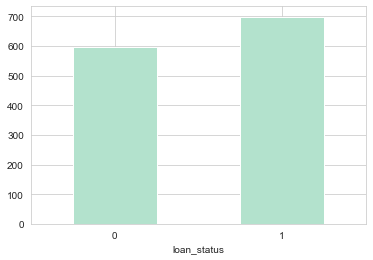

In [204]:
df.groupby("loan_status").last_fico_range_high.mean().plot.bar(colormap = 'Pastel2')
plt.xticks(rotation = 0);

It is obvious to see people who paid off their loan have higher FICO scores.

#### 2.2 Income vs. Loan Status

In [231]:
df['annual_inc'].describe()

count    4.238100e+05
mean     7.369043e+04
std      5.394186e+04
min      3.000000e+03
25%      4.500000e+04
50%      6.350000e+04
75%      9.000000e+04
max      7.500000e+06
Name: annual_inc, dtype: float64

In [232]:
df['log_annual_inc'] = df['annual_inc'].apply(lambda x:np.log10(x+1))

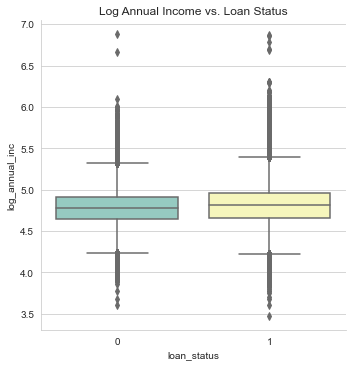

In [233]:
sns.catplot(data=df, kind = 'box', x = 'loan_status', y ='log_annual_inc' , palette = 'Set3')
plt.title("Log Annual Income vs. Loan Status");

Interestingly, the distribution of annual income is almost same no matter the borrowers paid off the loan or not.

In [234]:
df.drop(columns =['log_annual_inc'], inplace = True)

#### 2.3 Purpose vs Loan Status

In [110]:
df['purpose'].unique()

array(['credit_card', 'debt_consolidation', 'car', 'home_improvement',
       'house', 'other', 'medical', 'moving', 'major_purchase',
       'vacation', 'small_business', 'renewable_energy', 'wedding',
       'educational'], dtype=object)

In [208]:
purpose = df.groupby(['purpose','loan_status']).size().unstack()
purpose

loan_status,0,1
purpose,,
car,528,3255
credit_card,16791,81901
debt_consolidation,52887,201570
home_improvement,4237,19105
house,367,1476
major_purchase,1286,6231
medical,767,3083
moving,525,1841
other,3981,15286


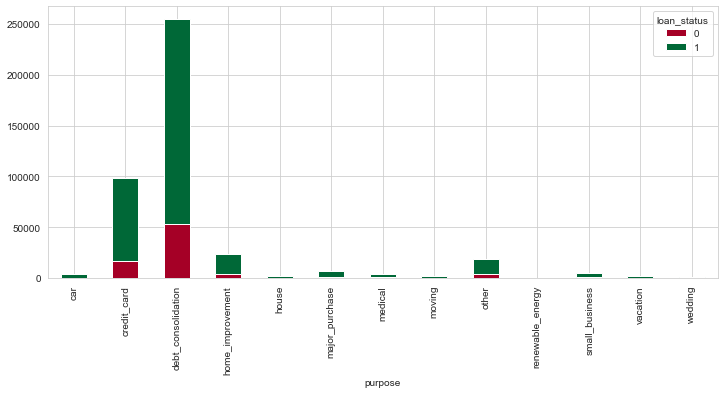

In [209]:
purpose.plot(kind ='bar', stacked = True, colormap = 'RdYlGn', figsize = (12,5));

The two main purpose for loan is credit card and debt consolidation, and more than 50% of borrowers paid it off.

#### 2.4 Bankruptices vs Loan Status

In [210]:
df.groupby('loan_status').pub_rec_bankruptcies.mean()

loan_status
0    0.114579
1    0.112156
Name: pub_rec_bankruptcies, dtype: float64

The mean value of public record bankruptices is almost the same for different loan status, for borrowers who paid off the loan, the public record bankruptcies is slightly lower.

### Feature Selection<a class="anchor" id="step3"></a>
After dropping columns with more than 30% missing values and id variable, we still have 93 columns. Next, I am going to use Boruta package to do the feature selection.


In [235]:
# Drop url and zip_code features since they are too many distinct values and not that useful
df.drop(labels = ['url','zip_code', 'id'], axis = 1, inplace = True)

In [236]:
feature_object = list(df.dtypes[df.dtypes == np.object].index)
feature_object

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'title',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

When I imported the datasets, there is a warning saying that some columns has mixed data types. I will convert the object variables to the same data type string before encoding.

In [237]:
for i in feature_object:
    df[i] = df[i].astype(str)

In [238]:
# Convert all object variables to numeric
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
for i in feature_object:
    df[i] = labelencoder.fit_transform(df[i].astype(str))

In [239]:
# Check the result
list(df.dtypes[df.dtypes == np.object].index)

[]

In [240]:
df.isnull().sum().sort_values(ascending=False)

mths_since_recent_inq    49560
mo_sin_old_il_acct       41043
num_tl_120dpd_2m         35857
pct_tl_nvr_dlq           27894
avg_cur_bal              27753
                         ...  
total_pymnt_inv              0
total_pymnt                  0
out_prncp_inv                0
out_prncp                    0
loan_amnt                    0
Length: 91, dtype: int64

Since there are still a lot of missing values in the columns, I will use mean value to impute the missing values. 

In [241]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy = 'mean')
imputer=imp.fit(df.iloc[:,:])

In [242]:
df.iloc[:,:] = imputer.transform(df.iloc[:,:])

In [243]:
# Check missing value
df.isnull().sum().sort_values(ascending=False)

loan_status              0
fico_range_high          0
open_acc                 0
pub_rec                  0
revol_bal                0
                        ..
mths_since_recent_bc     0
mths_since_recent_inq    0
num_accts_ever_120_pd    0
num_actv_bc_tl           0
loan_amnt                0
Length: 91, dtype: int64

In [244]:
y = df['loan_status']
X = df.drop(labels = ["loan_status"], axis = 1)

In [245]:
# Split train and test data set
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [165]:
# Define Random Forest classifier to be used by Boruta
model = RandomForestClassifier(n_jobs = -1)

In [166]:
# Define Boruta feature selection method
from boruta import BorutaPy
feat_selector = BorutaPy(model, n_estimators='auto', verbose = 2,random_state=1)

In [167]:
feat_selector.fit(X_train.values,y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	90
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	90
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	90
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	90
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	90
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	90
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	90
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	40
Tentative: 	8
Rejected: 	42
Iteration: 	9 / 100
Confirmed: 	40
Tentative: 	8
Rejected: 	42
Iteration: 	10 / 100
Confirmed: 	40
Tentative: 	8
Rejected: 	42
Iteration: 	11 / 100
Confirmed: 	40
Tentative: 	8
Rejected: 	42
Iteration: 	12 / 100
Confirmed: 	40
Tentative: 	8
Rejected: 	42
Iteration: 	13 / 100
Confirmed: 	40
Tentative: 	6
Rejected: 	44
Iteration: 	14 / 100
Confirmed: 	40
Tentative: 	6
Rejected: 	44
Iteration: 	15 / 100
Confirmed: 	40
Tentative: 	6
Rejected: 	44
Iteration: 	16 / 100
Confirmed: 	40
Tentative: 	6
Reject

BorutaPy(estimator=RandomForestClassifier(n_estimators=95, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x25D8B5B40),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x25D8B5B40,
         verbose=2)

After I ran the model, let us review the result.

In [170]:
feature_names = np.array(X.columns)

In [172]:

feature_ranks = list(zip(feature_names,
                        feat_selector.ranking_, 
                         feat_selector.support_))

In [183]:
# Print accepted featurs as well as features that boruta consider unimportant
accept = X.columns[feat_selector.support_].to_list()
not_accept = X.columns[feat_selector.support_weak_].to_list()

print('Accepted Features is total: {}, they are {}'.format(len(accept), accept))

Accepted Features is total: 41, they are ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'annual_inc', 'issue_d', 'title', 'dti', 'revol_bal', 'revol_util', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'debt_settlement_flag', 'year']


In [176]:
# Save the features in a list
important_features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 
                      'sub_grade', 'emp_title', 'annual_inc', 'issue_d', 'title', 'dti', 'revol_bal', 'revol_util', 
                      'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
                      'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
                      'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 
                      'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 
                      'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 
                      'debt_settlement_flag', 'year'
                     ]

After using Boruta feature selection, we reduced the feature from 93 to 41. Next, we are going to use these 41 features to predict the loan status.

In [246]:
# Select the 41 features from X_train dataset
new_X_train = X_train[important_features]
new_X_train.shape

(296667, 41)

In [247]:
new_X_test = X_test[important_features]
new_X_test.shape

(127143, 41)

### Modelling<a class="anchor" id="step4"></a>

Before I trained any models, I will first see the Null model accuracy to get a overall idea of the data.

-- **Null Model**

In [248]:
# Examine the distribution of the testing set
y_test.value_counts()

1.0    102059
0.0     25084
Name: loan_status, dtype: int64

In [249]:
# Calculate the null accuracy ones
max(y_test.mean(), 1- y_test.mean())

0.8027103340333326

We get about 80% accuracy for positive loan status if we don't run any models.

After splitting the train and test dataset, I will try Random Forest, XGboost, Logistic Regression and KNN to predict the loan status.

-- **Random Forest**

In [250]:

random_model = RandomForestClassifier(n_jobs = -1)

In [251]:
# Fitting Random Forest Classifier to train dataset
random_model.fit(new_X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [252]:
# predict on the test dataset
y_pred_rf = random_model.predict(new_X_test)

In [253]:
# Print accuracy score
print('Accuracy Score: ', metrics.accuracy_score(y_test, y_pred_rf))

Accuracy Score:  0.9971685425072556


In [254]:
# Print confusion matrix
cm_rf = confusion_matrix(y_test,y_pred_rf)
cm_rf

array([[ 24727,    357],
       [     3, 102056]])

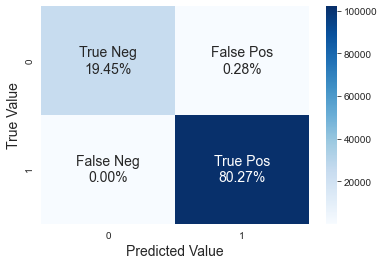

In [255]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_perct = ["{0:.2%}".format(value) for value in cm_rf.flatten()/np.sum(cm_rf)]

labels = [f"{v1}\n{v2}" for v1,v2 in 
         zip(group_names, group_perct)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm_rf, annot = labels, fmt='', cmap = 'Blues',annot_kws={"size": 14})
plt.xlabel("Predicted Value", fontsize = 14)
plt.ylabel("True Value", fontsize = 14);

#### XGboost

In [256]:
xgb_model = xgb.XGBClassifier()

In [257]:
# Fit the xgboost model for the new feature data set
xgb_model.fit(new_X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:51:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [258]:
# predict on the test dataset
y_pred_xg = xgb_model.predict(new_X_test)

In [259]:
# Print accuracy score
print('Accuracy Score for XGboost: ', metrics.accuracy_score(y_test, y_pred_xg))

Accuracy Score for XGboost:  0.9987730350864774


In [260]:
# Print confusion matrix
cm_xgb = confusion_matrix(y_test,y_pred_xg)
cm_xgb

array([[ 24933,    151],
       [     5, 102054]])

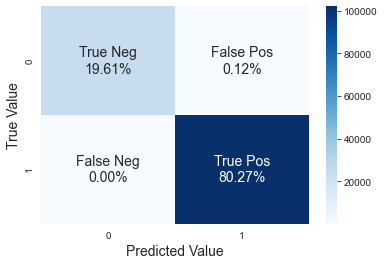

In [261]:
group_perct_xgb = ["{0:.2%}".format(value) for value in cm_xgb.flatten()/np.sum(cm_xgb)]
labels = [f"{v1}\n{v2}" for v1,v2 in 
         zip(group_names, group_perct_xgb)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_xgb, annot = labels, fmt='', cmap = 'Blues',annot_kws={"size": 14})
plt.xlabel("Predicted Value", fontsize = 14)
plt.ylabel("True Value", fontsize = 14);

#### Logistic Regression

In [262]:
log_model = LogisticRegression()

In [263]:
# Fit the xgboost model for the new feature data set
log_model.fit(new_X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [264]:
# predict on the test dataset
y_pred_log = log_model.predict(new_X_test)

In [265]:
# Print accuracy score
print('Accuracy Score for Logistic Regression: ', metrics.accuracy_score(y_test, y_pred_log))

Accuracy Score for Logistic Regression:  0.9955247241295234


In [266]:
# Print confusion matrix
cm_log = confusion_matrix(y_test,y_pred_log)
cm_log

array([[ 24537,    547],
       [    22, 102037]])

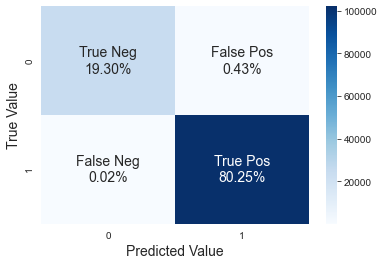

In [267]:
group_perct_log = ["{0:.2%}".format(value) for value in cm_log.flatten()/np.sum(cm_log)]
labels = [f"{v1}\n{v2}" for v1,v2 in 
         zip(group_names, group_perct_log)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_log, annot = labels, fmt='', cmap = 'Blues',annot_kws={"size": 14})
plt.xlabel("Predicted Value", fontsize = 14)
plt.ylabel("True Value", fontsize = 14);

#### KNN

Before fit KNN model, I need to standardize the variables

In [268]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(new_X_train)
new_X_train_scale = scaler.transform(new_X_train)
new_X_test_scale = scaler.transform(new_X_test)

In [269]:
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier(n_neighbors = 5)

In [270]:
KNN_model.fit(new_X_train_scale, y_train)

KNeighborsClassifier()

In [271]:
# Predict on the test dataset
y_pred_knn = KNN_model.predict(new_X_test_scale)

In [272]:
# Print accuracy score
print('Accuracy Score for KNN: ', metrics.accuracy_score(y_test, y_pred_knn))

Accuracy Score for KNN:  0.9550584774623849


In [273]:
# Print confusion matrix
cm_knn = confusion_matrix(y_test,y_pred_knn)
cm_knn

array([[ 20220,   4864],
       [   850, 101209]])

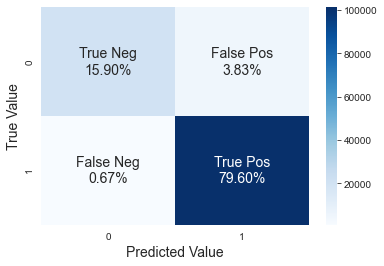

In [274]:
group_perct_knn = ["{0:.2%}".format(value) for value in cm_knn.flatten()/np.sum(cm_knn)]
labels = [f"{v1}\n{v2}" for v1,v2 in 
         zip(group_names, group_perct_knn)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_knn, annot = labels, fmt='', cmap = 'Blues',annot_kws={"size": 14})
plt.xlabel("Predicted Value", fontsize = 14)
plt.ylabel("True Value", fontsize = 14);

From the above three model, we can see XGBoost gives us the best accuracy rate and confusion matrix. Therefore, our best model is XGBoost.

Next, we will use this model to predict 2015 loan status for the company

### Predict loan status for 2015 use XGBoost<a class="anchor" id="step5"></a>
#### Data Pre-processing
Same pre-processing steps as before

In [354]:
data2.shape

(421095, 152)

In [275]:
# Drop url and zip_code features since they are too many distinct values and not that useful
data2.drop(labels = ['url','zip_code','id'], axis = 1, inplace = True)

In [276]:
# Encode the loan status
data2['loan_encode'] = np.where(data2['loan_status'] == 'Fully Paid', 1, 0)

In [277]:
# Drop loan_status column
data2.drop(['loan_status'], axis = 1, inplace = True)

In [278]:
# Rename loan_encode to loan_status
data2.rename(columns = {'loan_encode':'loan_status'},inplace = True)

In [279]:
feature_object2 = list(data2.dtypes[data2.dtypes == np.object].index)
feature_object2

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'title',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_loan_status',
 'disbursement_method',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date']

In [280]:
for i in feature_object2:
    data2[i] = data2[i].astype(str)

In [281]:
# Convert all object variables to numeric
labelencoder = LabelEncoder()
for i in feature_object2:
    data2[i] = labelencoder.fit_transform(data2[i].astype(str))

In [282]:
y_test_2015 = data2['loan_status']
x_test_2015 = data2[important_features]

In [283]:
# predict on the test dataset
y_pred_xgb_2015 = xgb_model.predict(x_test_2015)

In [284]:
# Print accuracy score
print('Accuracy Score for XGBoost for 2015: ', metrics.accuracy_score(y_test_2015, y_pred_xgb_2015))

Accuracy Score for XGBoost for 2015:  0.9979410821786058


In [285]:
# Print confusion matrix
cm_2015 = confusion_matrix(y_test_2015,y_pred_xgb_2015)
cm_2015

array([[120488,    865],
       [     2, 299740]])

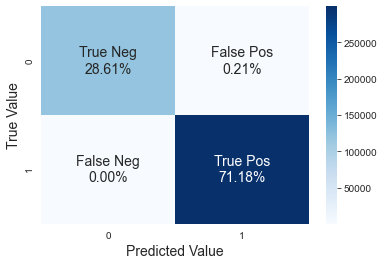

In [286]:
group_perct_2 = ["{0:.2%}".format(value) for value in cm_2015.flatten()/np.sum(cm_2015)]
labels = [f"{v1}\n{v2}" for v1,v2 in 
         zip(group_names, group_perct_2)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_2015, annot = labels, fmt='', cmap = 'Blues',annot_kws={"size": 14})
plt.xlabel("Predicted Value", fontsize = 14)
plt.ylabel("True Value", fontsize = 14);

### Conclusion<a class="anchor" id="step6"></a>

The predict accuracy is 99.80% only 0.08% lower than the previous dataset,which shows that this model is very stable and gets almost same result with the training dataset.

Below is the interpretion about the confusion matrix graphs.

False Negtive means the customer actually can fully pay the loan, but we predit they can't, and we won't take this customer, we lose business. False Positive means the customer acutually can't fully pay the loan, but we predit they can, and we accept such customer, and we lose money. If the we don't want to take the risk, we should more focus on the Fasle Positive rate, and find the model which can reduce the False Positve rate.
